In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [25]:
# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

## <font color="green">Нейронная сеть</font>

В этом блокноне Вы должны полностью реализовать свой вариант нейронной сети, пользуясь __только__
функциями __numpy__ и базового __python__. 

Естественно, при отладке и проверке можно ипользоватю любые другие пакеты (pandas, matplotlib, sklearn и т.д.)

В качестве итогового результата Вы должны получить сравнение результата работы Вашей сети со стандартными
вариантами сети из пакета sklearn на MINST и "малом" ImageNet

### <font color="red">ВАЖНО!</font> 
При реализации функций потерь и функций активации:
* Все функции должны работать с векторыми аргументами
* Можно использовать только простые функции из numpy(exp, sin и т.д.)
* Использовать уже реализованные в numpy функции активации и потерь __не допускается__<br><br>
В качестве __обязательного__ алгоритма оптимизации должен быть реализован стохастический градиентные спуск (SGD). Реализация его вариантов (инерция, Нестеров и т.д) будет плюсом.

In [8]:
# Функции активаци

def sigmoid(z):
    return 1/(1+np.exp(-z))

def tanh(z):
    return np.tanh(z)

def relu(z):
    return np.maximum(0,z)

In [179]:
class CrossEntropyCost(object):
    @staticmethod
    def loss_cross_ent(y_hat, y_true):
        return np.sum(np.nan_to_num(-y_true*np.log(y_hat)-(1-y_true)*np.log(1-y_hat)))
    
    @staticmethod
    def delta(z, y_hat, y_true, act_func):
        return (y_hat-y_true)
    
class MSECost(object):
    @staticmethod
    def loss_mse(y_hat, y_true):
        return np.square(np.subtract(y_true,y_hat)).mean() 
    
    @staticmethod
    def delta(z, y_hat, y_true , act_func):
        return act_func(y, y_hat) * act_func(z)

    



In [10]:
# Функции потерь

def loss_hinge(h, y):
    res = np.sum(np.dot(h,y))
    return 0 if res >= 1 else 1 - res




In [11]:
# Функции производных

def sigmoid_deriv(z):
    return sigmoid(z)*(1-sigmoid(z))

def tanh_deriv(z):
    return 1.0 - np.tanh(x)**2

def relu_deriv(z):
    alpha = 0.01
    dz = np.ones_like(z)
    dz[z < 0] = alpha
    return dz

In [346]:
# Класс, опредеающий один слой сети
class Layer():
    act_dict = {"sigm" : (sigmoid,sigmoid_deriv), "tanh": (tanh,tanh_deriv), "relu": (relu,relu_deriv)}
    
    def __init__(self, input_size,n_neurons,  activation=sigmoid, weights=None, bias=None, seed=21):

        np.random.seed(seed)
        self.weights = weights if weights is not None else np.random.rand(input_size, n_neurons)
        if activation == 'sigm':
            self.activation = self.act_dict['sigm'][0]
            self.deriv_act = self.act_dict['sigm'][1]
        elif activation == 'tanh':
            self.activation =self.act_dict['tanh'][0]
            self.deriv_act =self.act_dict['tanh'][1]
        else:
            self.activation =self.act_dict['relu'][0]
            self.deriv_act =self.act_dict['relu'][1]
        self.bias = bias if bias is not None else np.random.rand(n_neurons)
        self.last_activation = None
        self.error = None
        self.delta = None
        self.y_hat = None
        
        
        
    def activate(self, input_):
        y_hat = (np.dot(input_.reshape(1,-1),self.weights)+ self.bias)[0]
        self.last_activation = self._apply_activation(y_hat)
        
        return self.last_activation

    def _apply_activation(self, r):

        return self.activation(r)

    def apply_activation_derivative(self, r):
        
        return self.deriv_act(r)

        

In [379]:
# Класс, определяющий нейросеть в целом
class NeuralNet():
    def __init__(self,cost=CrossEntropyCost, nn_type='softmax'):
        self._layers = []
        self.cost = cost()
        self.nn_type = nn_type

    def __feedforward(self, X):
        
        for layer in self._layers:
            X = layer.activate(X)

        return X
        
    def __backprop(self, X, Y,learning_rate):

        # Feed forward for the output
        output = self.__feedforward(X)

        # Loop over the layers backward
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i]

            # If this is the output layer
            if layer == self._layers[-1]:
                layer.delta = (self.cost).delta(layer.last_activation, output, Y, layer.deriv_act)
            else:
                next_layer = self._layers[i + 1]
                layer.delta = (self.cost).delta(next_layer.last_activation, next_layer.y_hat, Y, next_layer.deriv_act)
          
        for i in range(len(self._layers)):
                layer = self._layers[i]
                # The input is either the previous layers output or X itself (for the first hidden layer)
                input_to_use = np.atleast_2d(X if i == 0 else self._layers[i - 1].last_activation)
                layer.weights += layer.delta * input_to_use.T * learning_rate  

    
    def add_layer(self,layer):
        self._layers.append(layer)

    def info(self):
        """
        выводит краткое описание всех слоев сети (включая входной и выходной)
        с указанием количества и типов нейронов в слое
        """

        pass

    def fit(self,X, y, n_epoch=100, learning_rate=1):
        """
        обучение нейронной сети
        X - входная переменная, массив [m , n_input]
        y - целевая переменная, массив [m , n_output]
        """

        mses = []

        for i in range(n_epoch):
            for j in range(len(X)):
                self.__backprop(X[j], y[j], learning_rate)
                mse = np.mean(np.square(y[j] - self.__feedforward(X[j])))
                mses.append(mse)
                print('Epoch: #%s, MSE: %f' % (i, float(mse)))

        return mses

    def predict(self,X):
        """
        X - входная переменная, массив [m , n_input]
        Возвращает массив [m , n_output]
        """
        
        ff = self.feed_forward(X)
        return ff

## Проверка работы сети

Проверка работы c sklearn должна быть выполнена полностью, а именно:
* выполнена кросс-валидация 
* выполнена проверка с помощью стандартной логистической регрессии с числом нейронов $(N_{input} + N_{output}) * log_2 {N_{records}}$, где $N_{input}$ - число входных переменных, $N_{output}$ - количество выходных переменных, $N_{records}$ - количество записей в выборке

* проверены несколько параметров сети и выбраны лучшие

Для запуска Вашей версии ледует использовать лучшие параметры, найденные на реализации с sklearn.

### MNIST

In [21]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.data.shape)

(1797, 64)


<Figure size 432x288 with 0 Axes>

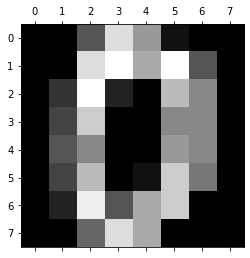

In [22]:
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show() 

In [332]:
### Код с применением стандартной sklearn
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))


In [333]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))


In [380]:
m = NeuralNet()
l = Layer(64,10)
m.add_layer(l)

In [381]:
l.weights.shape

(64, 10)

In [382]:
data[0].reshape(1,-1).shape

(1, 64)

In [383]:
( np.dot(data[0].reshape(1,-1),np.random.rand(64,10))+l.bias)[0]

array([135.93040463, 138.5800045 , 140.87402419, 154.85759855,
       128.86412761, 130.07639111, 167.54725182, 156.27039754,
       148.74487218, 135.79900361])

In [384]:
data[0].dot(l.weights) + l.bias

array([167.06256376, 155.45341628, 144.06085942, 151.31373448,
       166.41230479, 172.83595805, 136.17550854, 146.81041023,
       143.27719898, 138.4477128 ])

In [385]:
l.last_activation

In [386]:
data[0].reshape(1,-1).shape

(1, 64)

In [387]:
### Код с применением Вашей реализации
m.fit(data, digits.target)

Epoch: #0, MSE: 219822057766.267029
Epoch: #0, MSE: 1440147794989620992.000000
Epoch: #0, MSE: 18449116946540966038208512.000000
Epoch: #0, MSE: 41030220250121870518525813063680.000000
Epoch: #0, MSE: 128955241120054158245786563613644816384.000000
Epoch: #0, MSE: 1431661848622113337074213215770111602054922240.000000
Epoch: #0, MSE: 9040926151609853805391198846968370736278852023091200.000000
Epoch: #0, MSE: 23002581812585984382555040121317408166485017505571113271296.000000
Epoch: #0, MSE: 252224274296144045937713348488611419589163140642683458680212422656.000000
Epoch: #0, MSE: 2617546627226152703122117662144068698577188326181657169391711818723885056.000000
Epoch: #0, MSE: 15759711262534062003281160321979663556599324463703138927269419435136808883585024.000000
Epoch: #0, MSE: 139762121639428356245396825978312312887091272474854179755178899394462009792460276891648.000000
Epoch: #0, MSE: 282422790304331396339813473483739211485661297481204517960892568744616386073539168100746788864.000000
Epoc

/home/vika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in square
/home/vika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan
Epoch: #0, MSE: nan


Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan


Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan
Epoch: #1, MSE: nan


Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan
Epoch: #2, MSE: nan


Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan
Epoch: #3, MSE: nan


Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan


Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan
Epoch: #4, MSE: nan


Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan


Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan
Epoch: #5, MSE: nan


Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan
Epoch: #6, MSE: nan


Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan


Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan
Epoch: #7, MSE: nan


Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan
Epoch: #8, MSE: nan


Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan
Epoch: #9, MSE: nan


Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, M

Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, MSE: nan
Epoch: #10, M

Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, MSE: nan
Epoch: #11, M

Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, M

Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, M

Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, M

Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, MSE: nan
Epoch: #12, M

Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, M

Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, M

Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, MSE: nan
Epoch: #13, M

Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, M

Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, M

Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, M

Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, MSE: nan
Epoch: #14, M

Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, M

Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, MSE: nan
Epoch: #15, M

Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, MSE: nan
Epoch: #16, M

Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, M

Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, MSE: nan
Epoch: #17, M

Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, M

Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, MSE: nan
Epoch: #18, M

Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, MSE: nan
Epoch: #19, M

Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, M

Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan
Epoch: #20, MSE: nan

KeyboardInterrupt: 

### CIFAR-10

In [11]:
# https://www.cs.toronto.edu/~kriz/cifar.html

# Вам нужен файл:
# https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [12]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Loaded in this way, each of the batch files contains a dictionary with the following elements:<br><br>
* __data__ -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.<br><br>
* __labels__ -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In [13]:
### Код с применением стандартной sklearn


In [14]:
### Код с применением Вашей реализации
